In [76]:
from google.colab import drive
drive.mount('/content/drive/')
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed
from PIL import Image

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [62]:
image_dir = '/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/Datasets/BDD100k/bdd100k/bdd100k/images/100k/daytime'
mask_dir = '/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/Datasets/BDD100k/bdd100k_ins_seg/bdd100k/labels/ins_seg/colormaps/daytime'
predictions_daytime = '/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/predictions/daytime'
predictions_night = '/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/predictions/nighttime'
predictions_night_finetuned = '/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/predictions/finetuned_nighttime'

In [63]:
import os
import cv2
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_image_mask_pair(image_path, mask_path, target_size=(256, 256), num_classes=19):
    # Read and resize image
    img = cv2.imread(image_path, cv2.IMREAD_REDUCED_COLOR_2)  # Read at reduced size
    img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    img_normalized = (img_resized / 255.0).astype(np.float32)

    # Read and resize mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    mask_normalized = (mask_resized / 255.0).astype(np.float32)

    # Preprocess category IDs and one-hot encode the mask
    # category_ids = np.clip(mask_resized, 0, num_classes - 1)
    # encoded_mask = np.eye(num_classes, dtype=np.float32)[category_ids]

    return img_normalized, mask_normalized



def load_and_clean_data(image_dir, mask_dir, target_size=(256, 256), num_classes=1, max_images=1000):
    image_files = {os.path.splitext(f)[0]: f for f in sorted(os.listdir(image_dir))}
    mask_files = {os.path.splitext(f)[0]: f for f in sorted(os.listdir(mask_dir))}

    # Identify and delete unmatched files
    unmatched_images = set(image_files.keys()) - set(mask_files.keys())
    unmatched_masks = set(mask_files.keys()) - set(image_files.keys())

    for unmatched_img in unmatched_images:
        os.remove(os.path.join(image_dir, image_files[unmatched_img]))
        print(f"Deleted unmatched image: {image_files[unmatched_img]}")

    for unmatched_mask in unmatched_masks:
        os.remove(os.path.join(mask_dir, mask_files[unmatched_mask]))
        print(f"Deleted unmatched mask: {mask_files[unmatched_mask]}")

    # Process matched files
    matched_keys = list(set(image_files.keys()) & set(mask_files.keys()))[:max_images]

    images = []
    masks = []

    with ThreadPoolExecutor() as executor:
        future_to_key = {executor.submit(process_image_mask_pair,
                                         os.path.join(image_dir, image_files[img_name]),
                                         os.path.join(mask_dir, mask_files[img_name]),
                                         target_size,
                                         num_classes): img_name for img_name in matched_keys}

        for i, future in enumerate(as_completed(future_to_key)):
            img, mask = future.result()
            images.append(img)
            masks.append(mask)

            if (i + 1) % 100 == 0:
                print(f"Loaded {i + 1} image-mask pairs.")

    return np.array(images), np.array(masks)

In [64]:
def plot_images_masks_predictions(images, masks, predictions, indexes):
    """
    Plots specific samples of images, corresponding masks, and predicted masks.

    Args:
        images (numpy array): Array of images.
        masks (numpy array): Array of ground truth masks.
        predictions (numpy array): Array of predicted masks.
        indexes (list): List of indexes of images to display.
    """
    num_samples = len(indexes)
    plt.figure(figsize=(10, num_samples * 3))

    for i, idx in enumerate(indexes):
        # Ensure the index is within bounds
        if idx < 0 or idx >= len(images):
            print(f"Index {idx} is out of bounds. Skipping.")
            continue

        # Image
        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(images[idx])
        plt.title(f"Image {idx}")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(masks[idx].squeeze(), cmap='gray')
        plt.title(f"Ground Truth Mask {idx}")
        plt.axis("off")

        # Predicted mask
        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(predictions[idx].squeeze(), cmap='gray')
        plt.title(f"Predicted Mask {idx}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [65]:
def save_predictions(images, masks, predictions, indexes, save_folder):
    """
    Saves plots of specific samples of images, corresponding masks, and predicted masks to a folder.

    Args:
        images (numpy array): Array of images.
        masks (numpy array): Array of ground truth masks.
        predictions (numpy array): Array of predicted masks.
        indexes (list): List of indexes of images to save.
        save_folder (str): Folder path to save the plots.
    """
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    for idx in indexes:
        if idx < 0 or idx >= len(images):
            print(f"Index {idx} is out of bounds. Skipping.")
            continue

        fig, axes = plt.subplots(1, 3, figsize=(16, 5))  # Increased figure size

        axes[0].imshow(images[idx])
        axes[0].set_title(f"Image {idx}")
        axes[0].axis("off")

        axes[1].imshow(masks[idx].squeeze(), cmap='gray')
        axes[1].set_title(f"Ground Truth Mask {idx}")
        axes[1].axis("off")

        axes[2].imshow(predictions[idx].squeeze(), cmap='gray')
        axes[2].set_title(f"Predicted Mask {idx}")
        axes[2].axis("off")

        plt.tight_layout()
        save_path = os.path.join(save_folder, f"plot_{idx}.png")
        plt.savefig(save_path, dpi=300)  # Increased DPI for better quality
        plt.close(fig)

    print(f"Plots saved in folder: {save_folder}")

In [66]:
images, masks = load_and_clean_data(image_dir, mask_dir, target_size=(256, 256), num_classes=1, max_images=100)

Loaded 100 image-mask pairs.


In [67]:
def load_pretrained_model(model_path):

  def dice_loss(y_true, y_pred, smooth=1e-6):
      y_true_f = tf.keras.backend.flatten(y_true)
      y_pred_f = tf.keras.backend.flatten(y_pred)
      intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
      dice = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
      return 1 - dice

  def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

  new_model = tf.keras.models.load_model(
      model_path,
      custom_objects={'dice_loss': dice_loss,'combined_loss': combined_loss },
      safe_mode=False  # Allow lambda loading
  )

  return new_model

In [ ]:
# model = load_pretrained_model(model_path='/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/Models/Xception_unet_1.keras')

In [83]:
import tensorflow as tf  # Import TensorFlow at the top

model_path = '/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/Models/MobileNetV3_unet.keras'

# Define custom objects for loading (if using custom loss or metrics)
def dice_loss(y_true, y_pred, smooth=1e-6):
  y_true_f = tf.keras.backend.flatten(y_true)  # Use the imported tf
  y_pred_f = tf.keras.backend.flatten(y_pred)
  intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
  dice = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
  return 1 - dice

def combined_loss(y_true, y_pred):
  bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)  # Use the imported tf
  dice = dice_loss(y_true, y_pred)  # Use the imported tf
  return bce + dice

# Load the model with custom objects
model = tf.keras.models.load_model(
      model_path,
      custom_objects={'dice_loss': dice_loss, 'combined_loss': combined_loss},
      safe_mode=False
  )

# ... (Rest of your code)

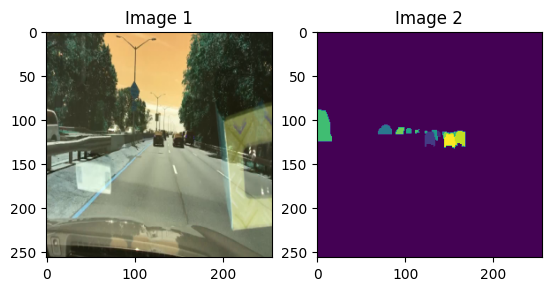

In [84]:
fig, axs = plt.subplots(1, 2)
idx = np.random.randint(0, len(images))
# Plot the image pairs
axs[0].imshow(images[idx])
axs[0].set_title('Image 1')
axs[1].imshow(masks[idx].squeeze())
axs[1].set_title('Image 2')

plt.show()

In [85]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ [(None, 128, 128, 64), │     23,587,712 │ input_layer_1[0][0]    │
│                           │ (None, 64, 64, 256),   │                │                        │
│                           │ (None, 32, 32, 512),   │                │                        │
│                           │ (None, 16, 16, 1024),  │                │                        │
│                           │ (None, 8, 8, 2048)]    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 256)    │      4,718,848 │ functional[0][4]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 1280)   │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ functional[0][3]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 256)    │      2,949,376 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 16, 16, 256)    │          1,024 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 256)    │        590,080 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 16, 256)    │          1,024 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 32, 32, 128)    │        295,040 │ batch_normalization_1… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 32, 32, 640)    │              0 │ conv2d_transpose_1[0]… │
│ (Concatenate)             │                        │                │ functional[0][2]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 128)    │        737,408 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 100,059,173 (381.70 MB)

 Trainable params: 33,334,689 (127.16 MB)

 Non-trainable params: 55,104 (215.25 KB)

 Optimizer params: 66,669,380 (254.32 MB)

In [86]:
import tensorflow as tf

model.fit(images, masks, epochs=2, batch_size=32)

Epoch 1/2


NameError: name 'tf' is not defined

In [71]:
predicted_mask = model.predict(images)

KeyboardInterrupt: 

[ 3 20 25 33 37 46 70 80 84 91]


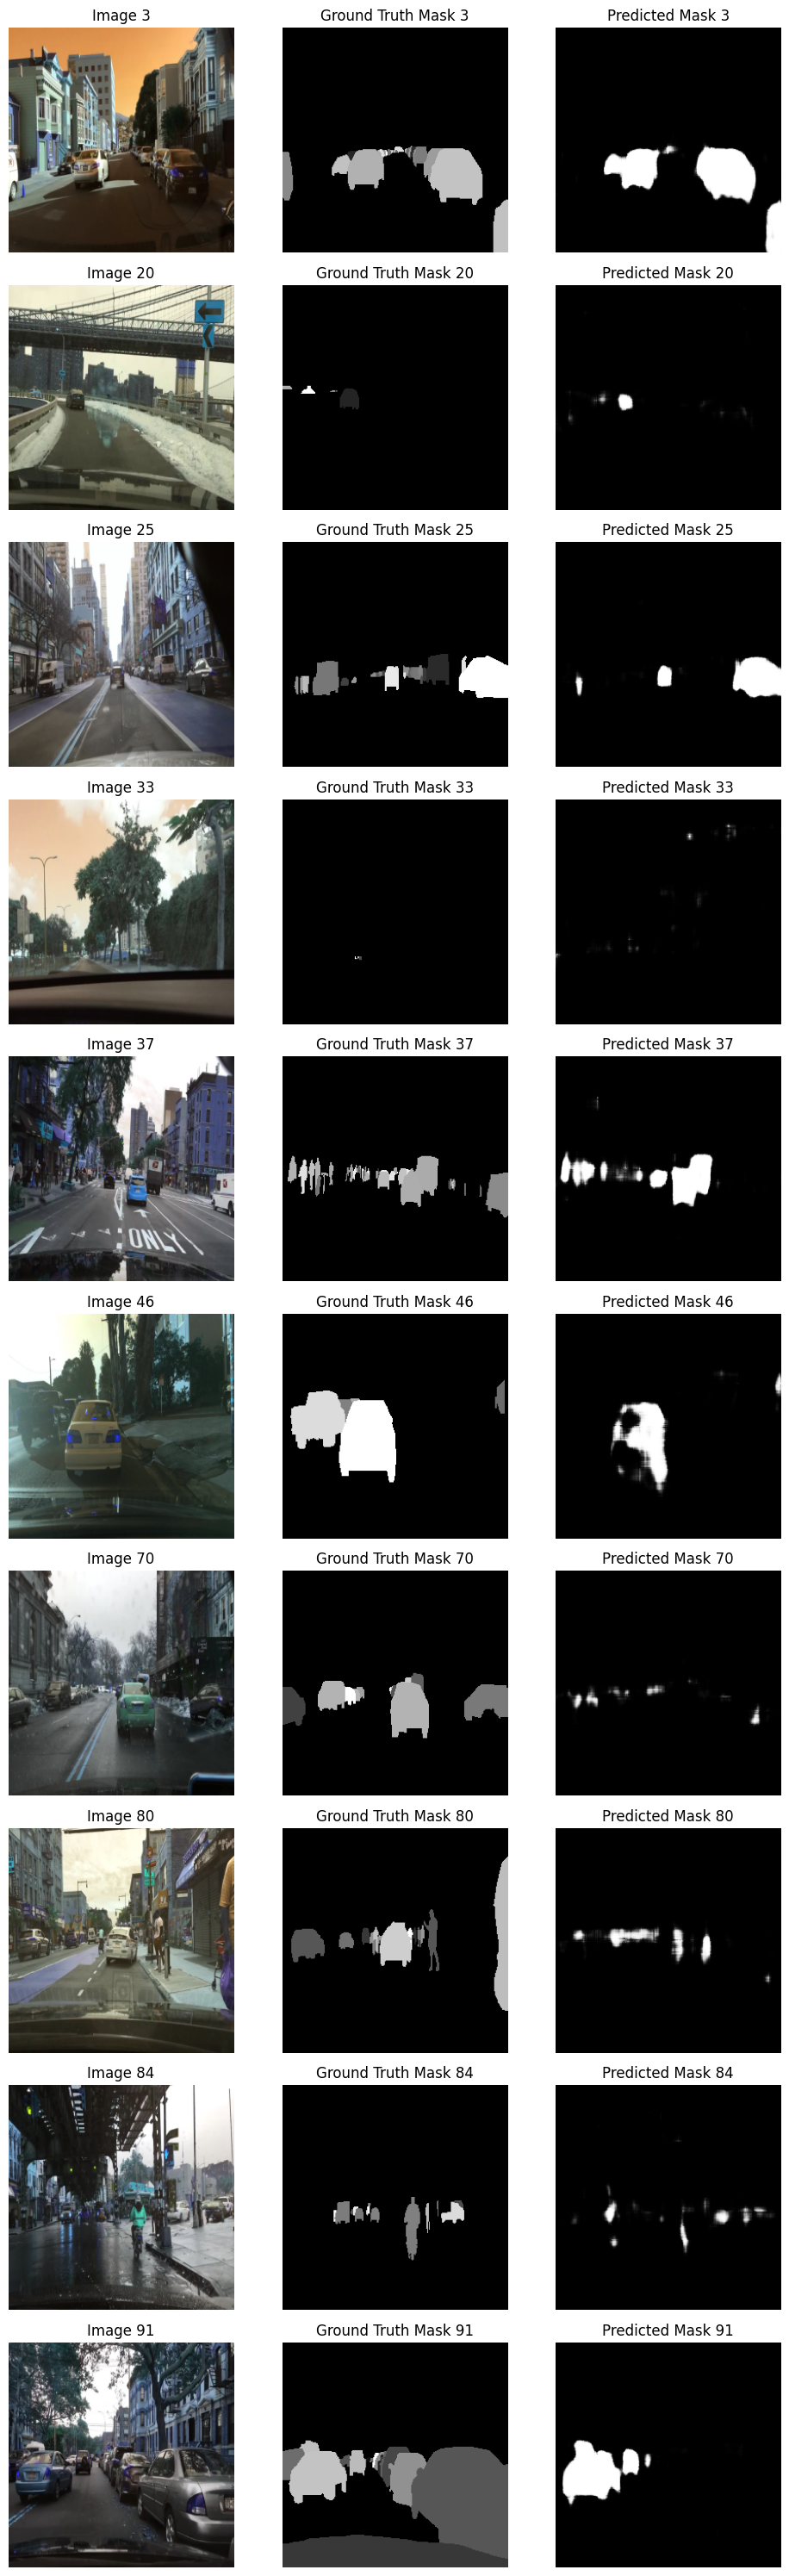

In [ ]:
idxs = np.random.randint(0, len(images), 10)
# idxs = np.array([10, 38, 45, 48, 46, 17, 72, 24, 79, 81, 88, 98, 93])
idxs = np.sort(idxs)
print(idxs)
plot_images_masks_predictions(images, masks, predicted_mask, indexes=idxs)

In [ ]:
# idxs = np.random.randint(0, len(images), 3)
idxs = np.array([10, 38, 45, 48, 46, 17, 72, 24, 79, 81, 88, 98, 93])
idxs = np.sort(idxs)
print(idxs)
save_predictions(images, masks, predicted_mask, indexes=idxs, save_folder=predictions_daytime)

[10 17 24 38 45 46 48 72 79 81 88 93 98]
Plots saved in folder: /content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/predictions/daytime


Model is able to detect car even if they are not in the ground truth.

[46 81]


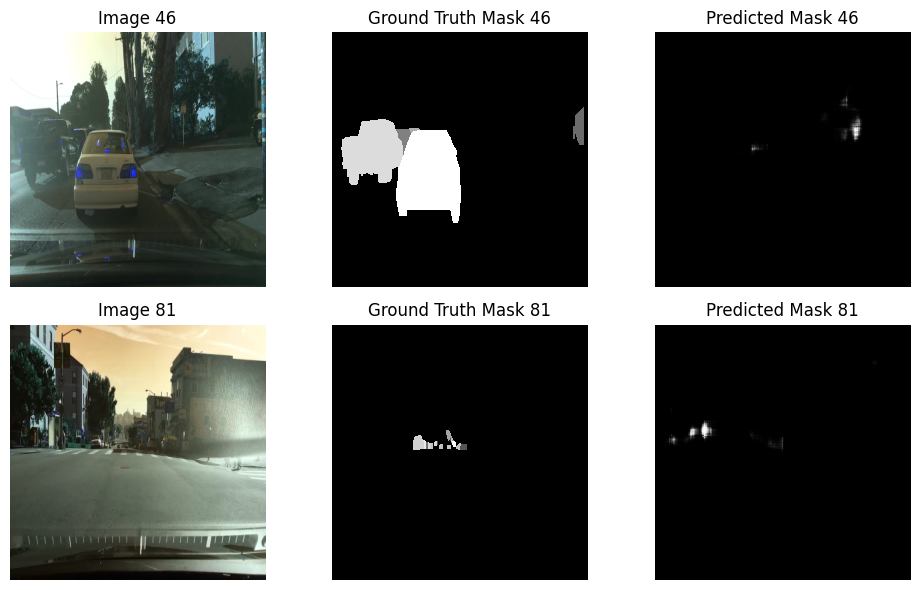

In [ ]:
idxs = np.array([81, 46])
idxs = np.sort(idxs)
print(idxs)
plot_images_masks_predictions(images, masks, predicted_mask, indexes=idxs)

In [ ]:
# idxs = np.random.randint(0, len(images), 3)
idxs = np.arange(80, 100)
idxs = np.sort(idxs)
print(idxs)
plot_images_masks_predictions(images, masks, predicted_mask, indexes=idxs)

In [ ]:
night_image_folder = "/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/Datasets/BDD100k/bdd100k/bdd100k/images/100k/night"
night_mask_folder = "/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/Datasets/BDD100k/bdd100k_ins_seg/bdd100k/labels/ins_seg/colormaps/night"

In [ ]:
night_images, night_masks = load_and_clean_data(night_image_folder, night_mask_folder, max_images=800)

Loaded 100 image-mask pairs.


In [ ]:
night_pred = model.predict(night_images)

4/4 ━━━━━━━━━━━━━━━━━━━━ 83s 20s/step


In [ ]:
# idxs = np.random.randint(0, len(images), 3)
idxs = np.arange(0, 40)
idxs = np.sort(idxs)
print(idxs)
plot_images_masks_predictions(night_images, night_masks, night_pred, indexes=idxs)

Output hidden; open in https://colab.research.google.com to view.

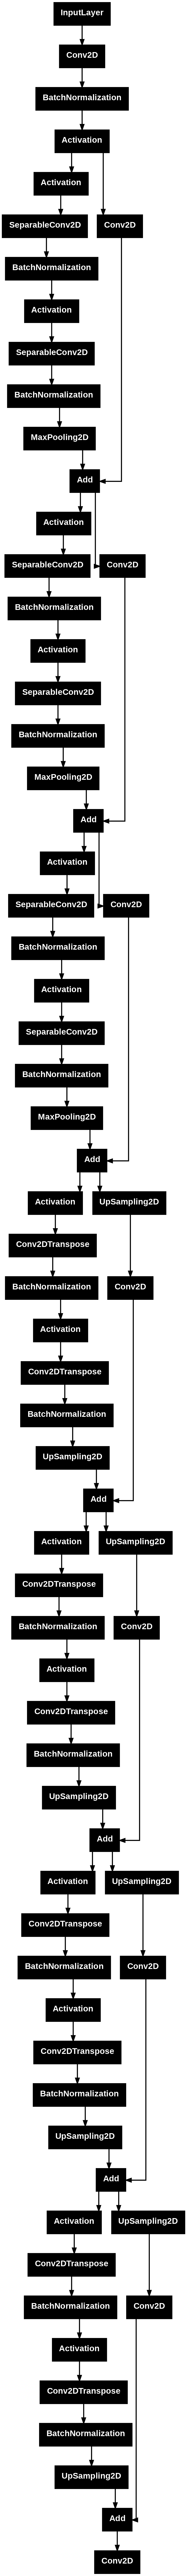

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/Models/Xception.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=200,
    show_layer_activations=False,
    show_trainable=False,
)

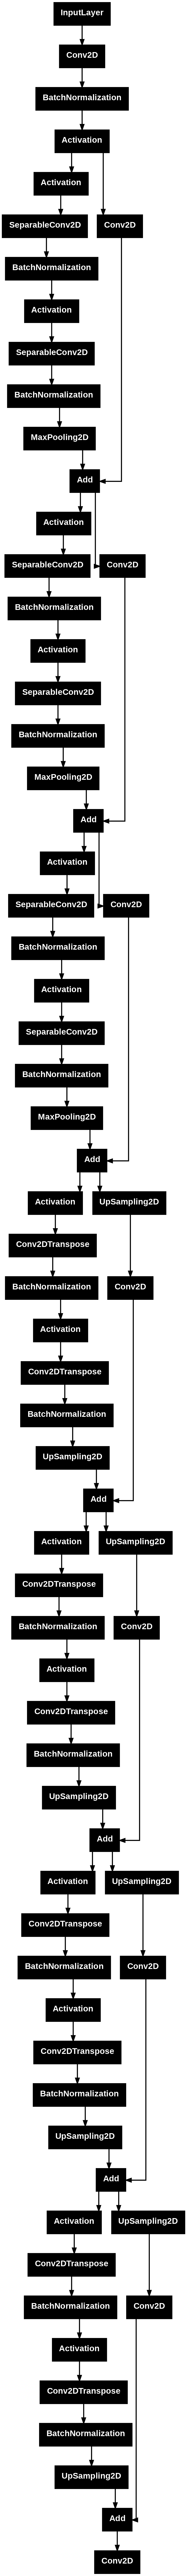

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/Models/Xception.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=200,
    show_layer_activations=False,
    show_trainable=False
)

# Fine Tuning

In [ ]:
def freeze_layers(model):
    for layer in model.layers[:5]:
        layer.trainable = False

    for layer in model.layers[-5:]:
        layer.trainable = False

    # for layer in model.layers[-5:]:
    #     layer.trainable = True

    return model

def compile_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def fine_tune_model(model, images, masks, epochs=10, batch_size=32):
    history = model.fit(
        x=images,
        y=masks,
        epochs=epochs,
        batch_size=batch_size
    )
    return model, history

In [ ]:
# Freeze encoder layers
# model = freeze_layers(model)

# Compile the model
model = compile_model(model)

In [ ]:
fine_tuned_model, history = fine_tune_model(model, night_images, night_masks, epochs=20)

In [ ]:
night_pred_fine_tuned = fine_tuned_model.predict(night_images)

In [ ]:
# idxs = np.random.randint(0, len(images), 3)
idxs = np.arange(0, 40)
idxs = np.sort(idxs)
print(idxs)
plot_images_masks_predictions(night_images, night_masks, night_pred_fine_tuned, indexes=idxs)

In [ ]:
# fine_tuned_model.save("/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/MobileNetV3_unet_fine_tuned.keras")